#### Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

games_df = pd.read_csv('./games.csv')

print(games_df.head())
print(games_df.info())


   Unnamed: 0                      Name Platform  Year_of_Release  \
0           0                Wii Sports      Wii           2006.0   
1           1         Super Mario Bros.      NES           1985.0   
2           2            Mario Kart Wii      Wii           2008.0   
3           3         Wii Sports Resort      Wii           2009.0   
4           4  Pokemon Red/Pokemon Blue       GB           1996.0   

          Genre  NA_sales  EU_sales  JP_sales  Other_sales  Critic_Score  \
0        Sports     41.36     28.96      3.77         8.45          76.0   
1      Platform     29.08      3.58      6.81         0.77           NaN   
2        Racing     15.68     12.76      3.79         3.29          82.0   
3        Sports     15.61     10.93      3.28         2.95          80.0   
4  Role-Playing     11.27      8.89     10.22         1.00           NaN   

  User_Score Rating  
0          8      E  
1        NaN    NaN  
2        8.3      E  
3          8      E  
4        NaN    Na

- Незначительное отсутствие значений в колонке Name, Year_of_Release, Genre необходимо обработать
- Значительное отсутствие значений для колонок Critic_Score, User_Score, Rating, необходимо понять будет ли это нам мешать в дальнейшей работе
- Year_of_Release представлено как значение с плавающей точкой, стоит привести его к int 
- User_Score представлено как object, стоит обработать его значения и привести к int

#### Шаг 2. Подготовьте данные

Изучим, в каких случаях мы получаем нулевые значения:

Можем избавится от строк с пустой колонкой Name, по всей видимости это ошибка сбора данных и таких строк всего 2 \
От строк с пустым годом также можно избавится без особых проблем. По большей части это либо старые игры, либо на непопулярных платформах. К тому же таких строк не так много от общего количества значений. \
В колонке user_score можно обнаружить необычное значение tbd. Как правило, такое значение можно встретить в колонках с незнаменитыми, не самыми продаваемыми играми. Можно предположить, что пользователи просто не заходят на страничку с игрой и не ставят ей оценки. В случае, если бы таких записей было немного, мы могли бы удалить такие значения. Однако, в нашем случае лучше будет пометить их как Nan, чтобы иметь возможность привести колонку к типу int, и не потерять данные остальные данные. \
Также видим пустые значения в колонках User_Score, Critic_Score, Rating, иногда (по всей видимости особенно когда игра появилась до создания системы оценки ESRB) пустые значения пересекаются в рамках одной колонке. \
Таких значений слишком много (около половины от общего числа данных), чтобы избавляться от них, но и в дальнейшей работе они нам не помешают, просто будем помнить про их существование

In [3]:
games_df.columns = games_df.columns.str.lower()
games_df = games_df[pd.notnull(games_df["year_of_release"]) & pd.notnull(games_df["name"])]
games_df["user_score"] = games_df["user_score"].replace("tbd", np.nan)
games_df["user_score"] = pd.to_numeric(games_df["user_score"], downcast='signed')
games_df["year_of_release"] = games_df["year_of_release"].astype(int)
games_df["total_sales"] = games_df["na_sales"] + games_df["eu_sales"] + games_df["jp_sales"] + games_df["other_sales"]
games_df.info()
games_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
total_sales        16444 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


#### Шаг 3. Проведите исследовательский анализ данных
###### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?


AxesSubplot(0.125,0.125;0.775x0.755)


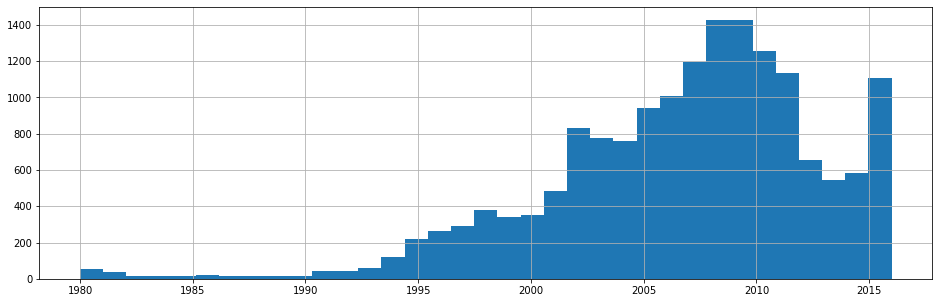

In [4]:
print(games_df["year_of_release"].hist(figsize=(16,5), bins=35))

в 1995 году наблюдаем резкое увеличение релизов игр. Будет разумно взять данные начиная с этого рубежа

AxesSubplot(0.125,0.125;0.775x0.755)


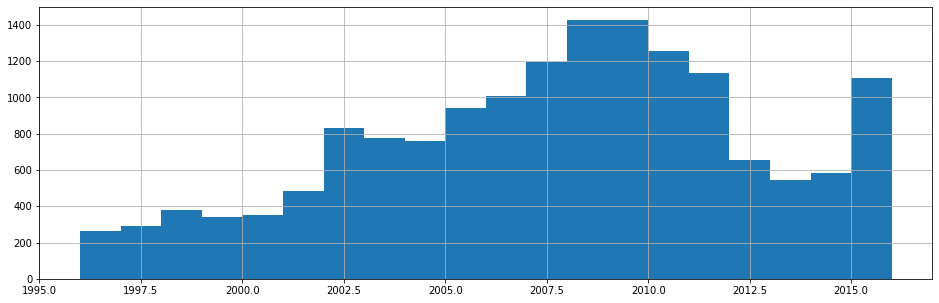

In [5]:
games_df = games_df.query("year_of_release > 1995")
print(games_df["year_of_release"].hist(figsize=(16,5), bins=20))

Так будет выглядеть обновленная гистограмма. Наблюдаем небольшое уменьшение релизов в 2012 - 2014 году и возрастание в 2015-2016

##### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Получим 5 самых популярных платформ и посмотрим как выглядит график их продаж.

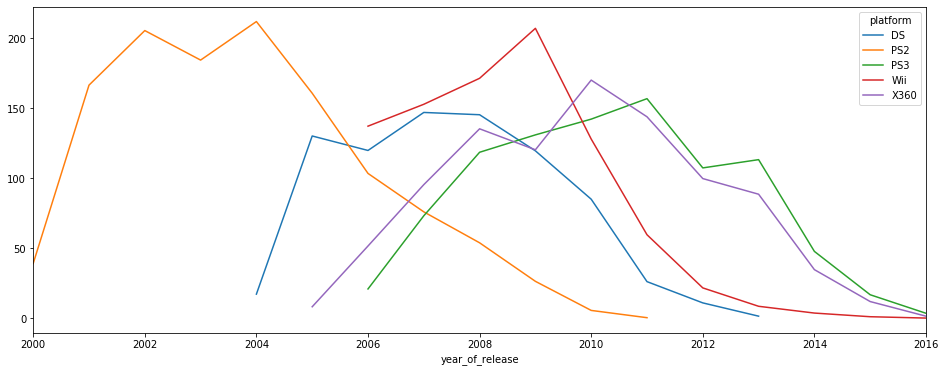

In [6]:
platf_by_popul = games_df.pivot_table(values='total_sales', 
                                      index=['platform'],
                                      aggfunc='sum').sort_values(by="total_sales", 
                                                                 ascending=False).head(5).index.get_level_values(0)
top5_full_df = games_df.query("platform in @platf_by_popul")
platf_by_years = top5_full_df.pivot_table(values='total_sales', 
                                          columns="platform",
                                          index=['year_of_release'],
                                          aggfunc='sum')
platf_by_years.plot(figsize=(16,6))

По графику видим, что жизненный цикл популярной платформы длится около 10 лет. Первые 5 лет платформа набирает популярность, и, достигнув пика, последующие 5 лет плавно движется вниз.
##### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
##### Не учитывайте в работе данные за предыдущие годы.

Т.к. мы считаем, что пик популярности платформы происходит примерно на 5 году после ее выпуска, найдем такую платформу, которая растет последние 4 года. Т.к. нам нужен прогноз на 2017 год, возьмем данные начиная с 2012 по 2016.

In [7]:
games_actual_df = games_df[games_df["year_of_release"] >= 2012]

##### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Возьмем 10 самых прибыльных платформ за последние 10 и сохраним их. В дальнейшем изучим, как много новых игр выпускалось на этой платформе, и отобразим это на графике.

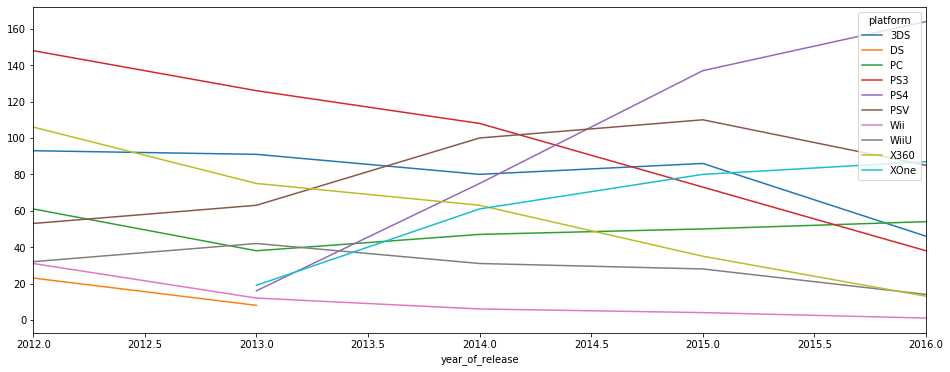

In [8]:
platf_by_popul_actual = games_actual_df.pivot_table(values='total_sales', 
                                      index=['platform'],
                                      aggfunc='sum').sort_values(by="total_sales", 
                                                                 ascending=False).head(10).index.get_level_values(0)
top5_full_actual_df = games_actual_df.query("platform in @platf_by_popul_actual")
platf_by_years_actual = top5_full_actual_df.pivot_table(values='total_sales', 
                                          columns="platform",
                                          index=['year_of_release'],
                                          aggfunc='count')
platf_by_years_actual.plot(figsize=(16,6))

Наиболее успешные платформы согласно графику - PS4, PC, XOne \
Платформы теряющие свою популярность - PS3, X360, Wii, 3DS \
Для PS4 - PS3, XOne - X360 четко заметна определенная в предыдущем шаге тенденция на смену поколений консоли раз в 10 лет.
PC в данном случае скорее исключение. Новых релизов на ней меньше, чем на основных популярных платформах, однако их число более стабильное относительно остальных платформ.

##### Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.
Возьмем три самые популярные консоли, полученные в предыдущем шаге. 

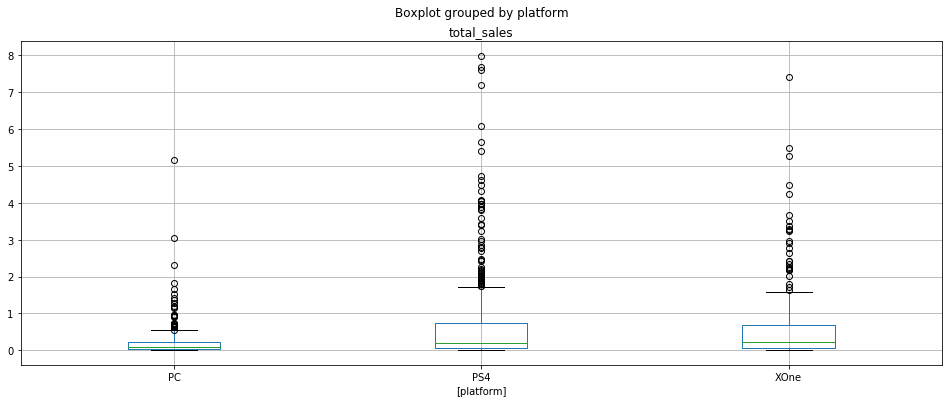

In [97]:
choosen_platf = ["PS4", "PC", "XOne"]
# отфильтруем данные из датафрейма по трем популярным платформам.
boxplot_df = games_actual_df.query("platform in @choosen_platf and total_sales < 8")
boxplot = boxplot_df[["platform", "total_sales"]]
boxplot.boxplot(by="platform", figsize=(16,6))

По ящику с усами видим, что в целом продажи PS4 превышают продажи прямого конкурента - XOne, и значительно превышают продажи на PC. PS4 имеет значительно больше "выстреливших" в продажах игр, однако в среднем Ps4 обгоняет XOne незначительно. \
Предположим, что большинство релизов, одновременно поддерживающих обе консоли, обеспечивают схожие средние Ps4 и XOne. Однако, по всей видимости, PS4 имеет значительное количество специфичных для платформы игр, имеющие высокую популярность у игроков и обеспечивающие высокие продажи.

##### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
В качестве популярной платформы возьмем PS4. Создадим датафрейм с играми выходившими на PS4 и построим диаграмму рассеяния между оценками пользователей и продажами.

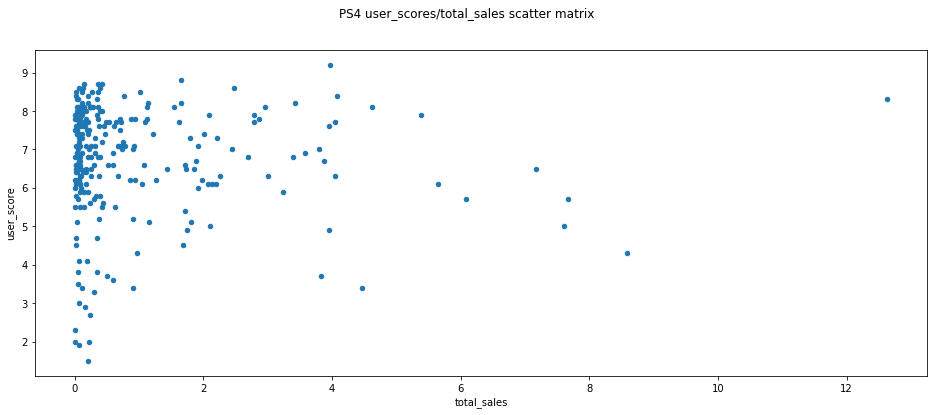

Correlation info: 
 -0.031957110204556424


In [93]:
def draw_scatter_matrix(df, x_column, y_column, title):
    df.plot.scatter(x=x_column, y=y_column, figsize=(16,6))
    plt.suptitle(title)
    plt.show()
    print('\033[1m' + 'Correlation info: \n' +  '\033[0m', df[y_column].corr(df[x_column]))

ps4_games_actual_df = games_actual_df[(games_actual_df["platform"] == "PS4") & (games_actual_df["total_sales"] > 0)]
draw_scatter_matrix(ps4_games_actual_df,'total_sales', 'user_score', 'PS4 user_scores/total_sales scatter matrix')

Аналогичным образом построим диаграмму для общих продаж и оценок критиков

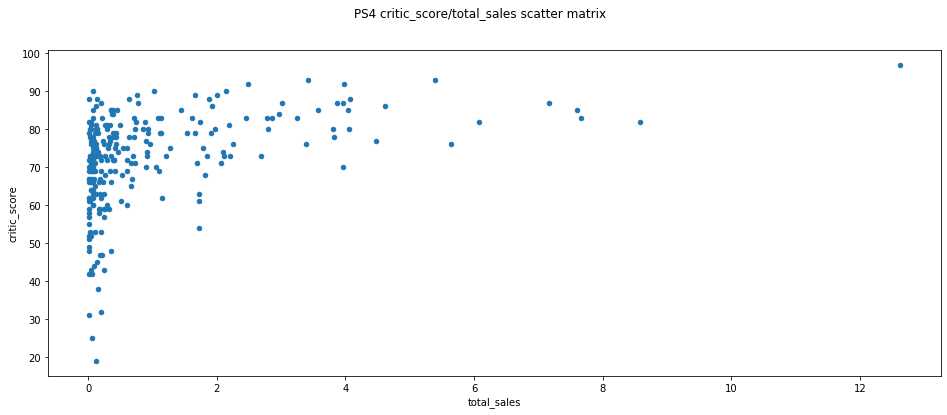

Correlation info: 
 0.40656790206178095


In [94]:
draw_scatter_matrix(ps4_games_actual_df,'total_sales', 'critic_score', 'PS4 critic_score/total_sales scatter matrix')

На первый взгляд графики схожи между собой, однако большое число игр с низкими оценками пользователей, но высокими продажами, объясняет разницу между числовым представлением корреляции для оценок пользователей, и оценок критиков. Можно сказать, что между оценками критиков и продажами игры есть слабая корреляция, тогда как для оценок пользователей такой корреляции не наблюдается

##### Соотнесите выводы с продажами игр на других платформах.

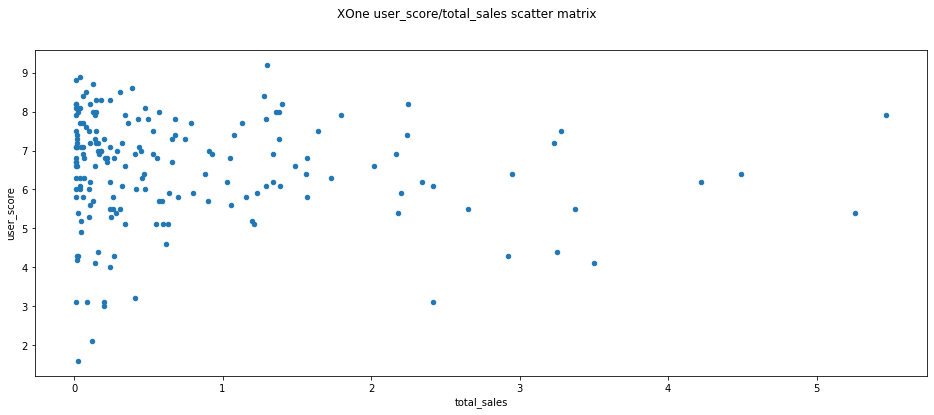

Correlation info: 
 -0.06892505328279414


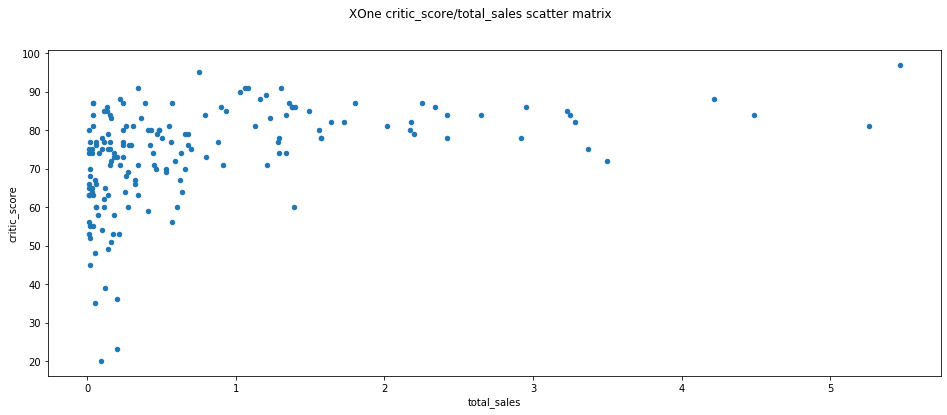

Correlation info: 
 0.4169983280084017


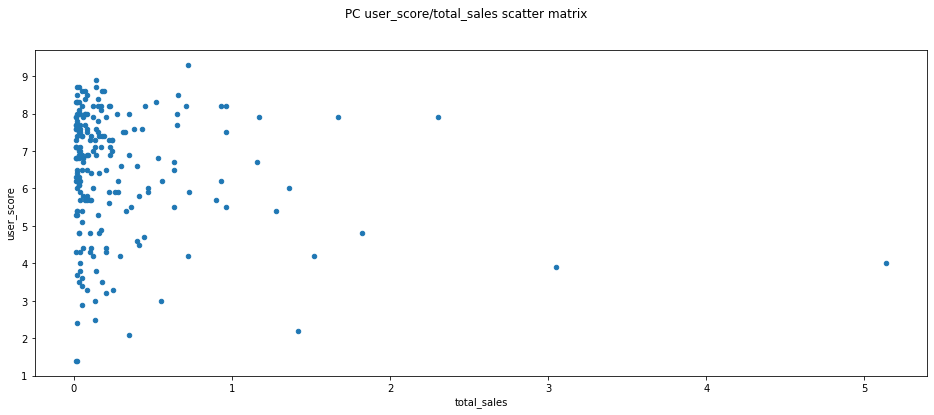

Correlation info: 
 -0.12186747630735577


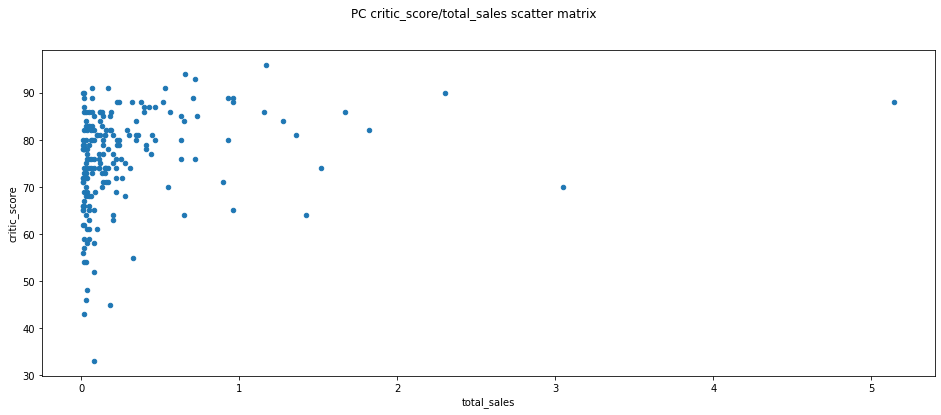

Correlation info: 
 0.23724324311567915


In [95]:
xone_games_actual_df = games_actual_df[(games_actual_df["platform"] == "XOne") & (games_actual_df["total_sales"] > 0)]
pc_games_actual_df = games_actual_df[(games_actual_df["platform"] == "PC") & (games_actual_df["total_sales"] > 0)]
draw_scatter_matrix(xone_games_actual_df,'total_sales', 'user_score', 'XOne user_score/total_sales scatter matrix')
draw_scatter_matrix(xone_games_actual_df,'total_sales', 'critic_score', 'XOne critic_score/total_sales scatter matrix')
draw_scatter_matrix(pc_games_actual_df,'total_sales', 'user_score', 'PC user_score/total_sales scatter matrix')
draw_scatter_matrix(pc_games_actual_df,'total_sales', 'critic_score', 'PC critic_score/total_sales scatter matrix')


Видим схожую ситуацию на остальных платформах. \
Для платформы XOne числовые показатели корреляции практически не отличаются от платформы PS, тогда как для PC они чуть ниже (у PC чуть меньше высокодоходных и высокооцененных игр, по всей видимости платформенные эксклюзивы). \
Т.к. критики оценивают игры на этапе релиза, а пользователи на всем жизненном цикле игры, предположим, что действия издателя или разработчика после релиза, вызвало неодназначную реакцию пользователей. Это, в свою очередь, могло привести к низким пользовательским оценкам для популярных и продаваемых игр.

##### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [13]:
games_info = games_actual_df.pivot_table(values='total_sales', 
                                          index=['genre'],
                                          aggfunc=['count', 'sum', 'mean'])
games_info.columns = ['sales_count', 'sales_sum', 'sales_mean']
print(games_info.sort_values("sales_sum", ascending = False))

              sales_count  sales_sum  sales_mean
genre                                           
Action               1031     441.12    0.427856
Shooter               235     304.73    1.296723
Role-Playing          370     192.80    0.521081
Sports                268     181.07    0.675634
Misc                  192      85.04    0.442917
Platform               85      61.00    0.717647
Racing                115      53.50    0.465217
Fighting              109      44.49    0.408165
Simulation             80      35.12    0.439000
Adventure             302      29.43    0.097450
Strategy               71      13.34    0.187887
Puzzle                 28       4.89    0.174643


Среди самых продаваемых жанров выделяются Action, Shooter, Role-Playing, Sports. \
Среди наименее продаваемых жанров выделяются Puzzle, Strategy, Adventure

Жанры, собравшие наименьшую сумму по всей видимости, это необязательно жанры с низким числом релизов. Например игр жанра Adventure даже больше, чем Shooter, хотя они диаметрально противоположны в графике. Возможно, причина по которой эти игры получают меньшую сумму, заключена в том, что пазлы, стратегии и приключенческие игры сложно реализовать на приставках, и продаются они в основном на PC, а как мы заметили ранее основную выручку приносят консоли. 

Проверим это утверждение

In [14]:
pc_games_info = pc_games_actual_df.pivot_table(values='total_sales', 
                                          index=['genre'],
                                          aggfunc=['count', 'sum', 'mean'])
pc_games_info.columns = ['sales_count', 'sales_sum', 'sales_mean']
print(pc_games_info.sort_values("sales_sum", ascending = False))

              sales_count  sales_sum  sales_mean
genre                                           
Shooter                41      14.27    0.348049
Role-Playing           27      13.65    0.505556
Action                 66      13.14    0.199091
Simulation             23       9.22    0.400870
Strategy               26       5.99    0.230385
Sports                 17       3.26    0.191765
Racing                 20       1.23    0.061500
Adventure              17       0.87    0.051176
Misc                    5       0.73    0.146000
Platform                3       0.14    0.046667
Fighting                3       0.12    0.040000
Puzzle                  2       0.03    0.015000


Предположение лишь отчасти верное, например в отношении стратегий, однако приключенческие игры и пазлы остаются примерно на том же уровне продаж.

#### Шаг 4. Составьте портрет пользователя каждого региона

Подготовим функцию для вывода данных по регионам

In [80]:
def print_popular_by_regions(df, region_name, region_column):
    column_sum = df[region_column].sum()
    local_games = df[["genre", "platform", "name", region_column, 'rating']]
    local_games_by_genre = local_games.pivot_table(index='genre', values=region_column, aggfunc='sum')
    local_games_by_genre["genre_percentage"] = local_games_by_genre[region_column].apply(lambda x: "{:.0f}".format(100 * (x / column_sum))).astype(int)
    
    print("\n Top 5 most popular for genre in {} region".format(region_name))
    print(local_games_by_genre.sort_values(ascending = False, by="genre_percentage").head())
    local_games_by_platform = local_games.pivot_table(index='platform', values=region_column, aggfunc='sum')
    local_games_by_platform["platform_percentage"] = local_games_by_platform[region_column].apply(lambda x: "{:.0f}".format(100 * (x / column_sum))).astype(int)
    
    print("\n Top 5 most popular for platform in {}".format(region_name))
    print(local_games_by_platform.sort_values(ascending = False, by="platform_percentage").head())
    print("Correlation")    
    local_games.pivot_table(index='rating', values=region_column, aggfunc='sum').plot(kind='bar')
    plt.show()
    
print(games_actual_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 16 to 16714
Data columns (total 12 columns):
name               2886 non-null object
platform           2886 non-null object
year_of_release    2886 non-null int64
genre              2886 non-null object
na_sales           2886 non-null float64
eu_sales           2886 non-null float64
jp_sales           2886 non-null float64
other_sales        2886 non-null float64
critic_score       1312 non-null float64
user_score         1531 non-null float64
rating             1611 non-null object
total_sales        2886 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 293.1+ KB
None


Europe sales info

 Top 5 most popular for genre in Europe region
              eu_sales  genre_percentage
genre                                   
Action          159.34                31
Shooter         113.47                22
Sports           69.09                14
Role-Playing     48.53                10
Misc             26.32                 5

 Top 5 most popular for platform in Europe
          eu_sales  platform_percentage
platform                               
PS4         141.09                   28
PS3         106.86                   21
X360         74.52                   15
XOne         51.59                   10
3DS          42.64                    8
Correlation


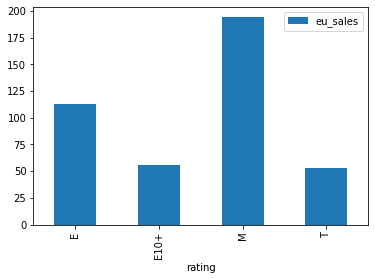

In [81]:
print('\033[1m' + 'Europe sales info' +  '\033[0m')
print_popular_by_regions(games_actual_df, "Europe", "eu_sales")

Данные по Европе коррелируют с ншими предыдущими наюлюдениями. Наиболее популярная платформа - PS4, самый популярный жанр - Action. \
Можем считать, что рейтинг игр незначительно влияет на уровень продаж по региону. Игры, с рейтингом M пользуются наибольшой популярностью, хоть и по идее имеет наибольшее ограничение на аудиторию.

North America sales info

 Top 5 most popular for genre in North America region
              na_sales  genre_percentage
genre                                   
Action          177.84                30
Shooter         144.77                24
Sports           81.53                14
Role-Playing     64.00                11
Misc             38.19                 6

 Top 5 most popular for platform in North America
          na_sales  platform_percentage
platform                               
X360        140.05                   24
PS4         108.74                   18
PS3         103.38                   17
XOne         93.12                   16
3DS          55.31                    9
Correlation


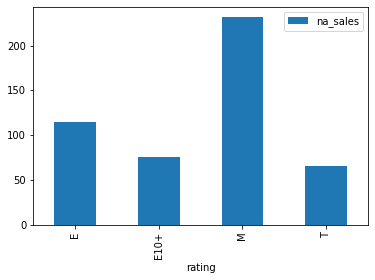

In [82]:
print('\033[1m' + 'North America sales info' +  '\033[0m')
print_popular_by_regions(games_actual_df, "North America", "na_sales")

Данные по Северной Америке схожи с информацией по Европе. Оба региона имеют общий наиболее популярный жанр и схожее распределение игр по рейтингу. \
Это можно объяснить тем, что XBox выпускает американская компания Microsoft, и ее присутствие на американском рынке ожидаемо выше.

Japan sales info 


 Top 5 most popular for genre in Japan region
              jp_sales  genre_percentage
genre                                   
Role-Playing     65.44                34
Action           52.80                27
Misc             12.86                 7
Fighting          9.44                 5
Shooter           9.23                 5

 Top 5 most popular for platform in Japan
          jp_sales  platform_percentage
platform                               
3DS          87.79                   46
PS3          35.29                   18
PSV          21.04                   11
PS4          15.96                    8
WiiU         13.01                    7
Correlation


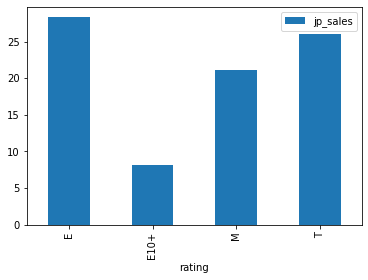

In [83]:
print('\033[1m' + 'Japan sales info' +  '\033[0m \n')
print_popular_by_regions(games_actual_df, "Japan", "jp_sales")

Данные по японскому рынку заметно отличаются от американских и европейских. \
В японском регионе значительно выше уровень популярности ролевых игры, что можно объяснить наличием очень популярных в японии специфичных для региона JRPG (Japanese Role-Playing Game) \
Самая популярная платформа в Японии - 3DS. По аналогии с XBox в Америке, 3DS популярная приставка японской компании Nintendo. Факт поддержки отечественного производителя важный по всей видимости факт при покупке консоли. \
Также в Японии заметно строже подходят к рейтингу игр. Большинство релизов относятся к детским и подростковым играм.


#### Шаг 5. Проверьте гипотезы

##### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Необходимо выяснить одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC. \
Отметим, что для обоих гипотез нам необходимо выяснить различие оценок, при этом не обязательно выяснять в большую или меньшую сторону. \
Данные по выручке лежат в двух разных, независимых выборках. \
Учитывая, что нам необходимо обработать выборки и выяснить степень равенства среднего будем использовать метод scipy.stats.ttest_ind \
В качестве порогового значения в обоих гипотезах укажем 1%

Сформулируем нулевую гипотезу следующим образом: средние пользовательские рейтинги платформ Xbox One и PC схожие, тогда альтернативная гипотеза будет говорить о различии пользовательских рейтингов.

In [19]:
xbox_scores = games_actual_df[games_actual_df["platform"] == "XOne"]["user_score"].dropna()
pc_scores = games_actual_df[games_actual_df["platform"] == "PC"]["user_score"].dropna()

alpha = .01

tariff_results = st.ttest_ind(
    xbox_scores, 
    pc_scores, equal_var = False)

print('p-значение:', tariff_results.pvalue)
# если полученное значение меньше уровня критической значимости опровергнем теорию
if (tariff_results.pvalue < alpha):
    print("Опровергаем гипотезу о схожести оценок «XBOX» и «PC»")
else:
    print("Не удалось опровергнуть гипотезу о схожести оценок «XBOX» и «PC»")



p-значение: 0.5489537965134912
Не удалось опровергнуть гипотезу о схожести оценок «XBOX» и «PC»


По всей видимости оценки пользователей не сильно зависят от выбранной ими платформы, а скорее от самой игры

##### Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.
Общие условия схожи с условиями предыдущей гипотезы, только работаем по другим выборкам.
Возьмем оценки по жанрам, и сформулируем гипотезу.
Нулевую гипотезу определим следующим образом: средние пользовательские рейтинги  жанров Sports и Action схожие, тогда альтернативная гипотеза будет говорить о различии пользовательских рейтингов.

In [20]:
action_scores = games_actual_df[games_actual_df["genre"] == "Action"]["user_score"].dropna()
sports_scores = games_actual_df[games_actual_df["genre"] == "Sports"]["user_score"].dropna()

alpha = .01

tariff_results = st.ttest_ind(
    action_scores, 
    sports_scores, equal_var = False)

print('p-значение:', tariff_results.pvalue)
# если полученное значение меньше уровня критической значимости опровергнем теорию
if (tariff_results.pvalue < alpha):
    print("Опровергаем гипотезу о схожести оценок жанров Sports и Action")
else:
    print("Не удалось опровергнуть гипотезу о схожести оценок жанров Sports и Action")

p-значение: 4.24307776572644e-20
Опровергаем гипотезу о схожести оценок жанров Sports и Action


Не удалось опровергнуть, что средние пользовательские оценки жанров Sports и Action значительно различаются.